This notebook is meant to allow the data collection / plotting of any quantum state we can produce in the set up.

In [12]:
# pip install uncertainties, tensorflow, matplotlib, pandas, tqdm, sympy, scipy

In [1]:
# TODO: Update this header
'''
Author: Lev Gruber
Last Update: 6/2/2024

This file uses code from Oscar's process_expt_richard.py in Summer 2023 to brute force
calculate eta and chi values (for the state cos(eta)PHI+ + sin(eta)e^i*chi PHI-) in which W is positive
and W' is negative. 

It does so by:
1. Creating theoretical density matrices at a variety of eta values and 1-2 chi values
2. Computing both W and W' witnesses for each density matrix
3. Pushing values with +W and -W' into one df, and values with +W, +W' into another. 

In the future, I hope to add functionality to compute V witnesses for states for which W and W' are positive.
'''

# Imports
import numpy as np
from os.path import join, dirname, abspath
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import sympy as sp
from uncertainties import ufloat
from uncertainties import unumpy as unp


# Get the absolute path of the project root to import code in finding_states
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)

# sys.path.append("c:\\Users\\izgod\\Fall-2024-Spring-2025\\finding_states")
print(sys.path)

# Original code adapted from Oscar Scholin in Summer 2023

import finding_states.states_and_witnesses as sw
import finding_states.operations as op
from test_states import *

/Users/bmendoza/Documents/College/Lynn Research/Code
['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/bmendoza/Library/Python/3.12/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages', '/Users/bmendoza/Documents/Programming/flask-tutorial', '/Users/bmendoza/Documents/College/Lynn Research/Code']


In [2]:
### Helper Functions ###
def ket(data):
    return np.array(data, dtype=complex).reshape(-1,1)

def get_theo_rho(state, eta, chi):
    '''
    Calculates the density matrix (rho) for a given set of paramters (eta, chi) for Stuart's states
    
    Parameters:
    state (string): Which state we want
    eta (float): The parameter eta.
    chi (float): The parameter chi.
    
    Returns:
    numpy.ndarray: The density matrix (rho)
    '''
    # Define kets and bell states in vector form 
    H = ket([1,0])
    V = ket([0,1])
    R = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (-1j)])
    L = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (1j)])
    D = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (1)])
    A = ket([1/np.sqrt(2) * 1, 1/np.sqrt(2) * (-1)])
    
    PHI_PLUS = (np.kron(H,H) + np.kron(V,V))/np.sqrt(2)
    PHI_MINUS = (np.kron(H,H) - np.kron(V,V))/np.sqrt(2)
    PSI_PLUS = (np.kron(H,V) + np.kron(V,H))/np.sqrt(2)
    PSI_MINUS = (np.kron(H,V) - np.kron(V,H))/np.sqrt(2)
    
    ##  The following 2 states inspired the Ws
    
    if state == 'phi plus, phi minus':
        phi = np.cos(eta)*PHI_PLUS + np.exp(1j*chi)*np.sin(eta)*PHI_MINUS
    
    if state == 'psi plus, psi minus':
        phi = np.cos(eta)*PSI_PLUS + np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    ## The following 6 states inspired the W primes
    
    if state == 'phi plus, psi minus':
        phi = np.cos(eta)*PHI_PLUS + np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    if state == 'phi minus, psi plus':
        phi = np.cos(eta)*PHI_MINUS + np.exp(1j*chi)*np.sin(eta)*PSI_PLUS
    
    if state == 'phi plus, i psi plus':
        phi = np.cos(eta)*PHI_PLUS + 1j*np.exp(1j*chi)*np.sin(eta)*PSI_PLUS
    
    if state == 'phi plus, i phi minus':
        phi = np.cos(eta)*PHI_PLUS + 1j*np.exp(1j*chi)*np.sin(eta)*PHI_MINUS

    if state == 'psi plus, i psi minus':
        phi = np.cos(eta)*PSI_PLUS + 1j*np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    if state == 'phi minus, i psi minus':
        phi = np.cos(eta)*PHI_MINUS + 1j*np.exp(1j*chi)*np.sin(eta)*PSI_MINUS
    
    ## The following state(s) are an attempt to find new positive W negative W prime states.
    if state == 'HR_VL':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,R) + (1 - np.exp(1j*chi))/2 * np.kron(V,L)
    
    if state == 'HR_iVL':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,R) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,L)
    
    if state == 'HL_VR':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,L) + (1 - np.exp(1j*chi))/2 * np.kron(V,R)
        
    if state == 'HL_iVR':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,L) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,R)
        
    if state == 'HD_VA':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,D) + (1 - np.exp(1j*chi))/2 * np.kron(V,A)
    
    if state == 'HD_iVA':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,D) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,A)
        
    if state == 'HA_VD':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,A) + (1 - np.exp(1j*chi))/2 * np.kron(V,D)
    
    if state == 'HA_iVD':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,A) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,D)
    
    if state == 'HR_minVL':
        phi = (1 + np.exp(1j*chi))/2 * np.kron(H,R) + 1j*(1 - np.exp(1j*chi))/2 * np.kron(V,L)
        
    if state == 'cosHD_sinVA':
        phi = np.cos(chi) * np.kron(H,D) + np.sin(chi)*np.kron(V, A)

    if state == 'cosHR_minussinVL':
        phi = np.cos(chi/2) * np.kron(H, R) - np.sin(chi/2) * np.kron(V,L)
    
    if state == 'cosHR_sinVL':
        phi = np.cos(chi/2) * np.kron(H, R) + np.sin(chi/2) * np.kron(V, L)
    
    if state == 'cosHR_minusisinVL':
        phi = np.cos(chi/2) * np.kron(H, R) - 1j * np.sin(chi/2) * np.kron(V, L)
        
    if state == 'cosHR_minusisinVL':
        phi = np.cos(chi/2) * np.kron(H, R) - 1j * np.sin(chi/2) * np.kron(V,L)
        
    if state == 'cosHL_sinVR':
        phi = np.cos(chi/2) * np.kron(H, L) + np.sin(chi/2) * np.kron(V, R)
        
    if state == 'cosHD_minussinVA':
        phi = np.cos(chi/2) * np.kron(H,D) - np.sin(chi/2) * np.kron(V,A)
        
    if state == 'cosHA_sinVD':
        phi = np.cos(chi/2) * np.kron(H,A) + np.sin(chi/2) * np.kron(V,D)
        
    if state == 'cosHA_isinVD':
        phi = np.cos(chi/2) * np.kron(H,A) + 1j * np.sin(chi/2) * np.kron(V,D)
    
    if state == 'cosHA_minussinVD':
        phi = np.cos(chi/2) * np.kron(H,A) - np.sin(chi/2) * np.kron(V,D)
        
    if state == 'cosHA_minusisinVD':
        phi = np.cos(chi/2) * np.kron(H,A) - 1j * np.sin(chi/2) * np.kron(V,D)
    
    if state == 'testof_hrivl_expt_match':
        phi = np.cos(chi/2) * np.kron(H,R) + np.exp(1j* 2*np.pi/3)*np.sin(chi/2) * np.kron(V, L)
    
    if state == 'testof_hdiva_expt_match':
        phi = np.cos(chi/2) * np.kron(H,D) + np.exp(-1j* np.pi/3)*np.sin(chi/2) * np.kron(V, A)
        
    if state == 'HD':
        phi = np.kron(H, D)
        
    if state == 'HA':
        phi = np.kron(H, A)
    
    if state == 'VD':
        phi = np.kron(V, D)
        
    if state == 'VA':
        phi = np.kron(V, A)
        
    if state == 'HR':
        phi = np.kron(H,R)
    
    if state == 'VL':
        phi = np.kron(V,L)
        
    ### The following states are states we can potentially create in our apparatus w/ +W, -W' without post-processing mixing ###
    ### Note eta is defined differently for these states
    if state == 'phase_test_hdva':
        phi = np.cos(chi/2) * np.kron(H, D) + np.exp(-1j * eta) * np.sin(chi/2) * np.kron(V, A)
    
    if state == 'phase_test_hhvv':
        phi = np.cos(chi/2) * np.kron(H, H) + np.exp(-1j * eta) * np.sin(chi/2) * np.kron(V, V)
        
    if state == 'phase_test_hvvh':
        phi = np.cos(chi/2) * np.kron(H, V) + np.exp(-1j * eta) * np.sin(chi/2) * np.kron(V, H)

    if state == 'phase_test_hrvl':
        phi = np.cos(chi/2) * np.kron(H, R) + np.exp(-1j * eta) * np.sin(chi/2) * np.kron(V, L)
        
    if state =='cosHA_minusphasesinVD':
        phi = np.cos(chi/2) * np.kron(H, A) + np.exp(-1j * 1.27) * np.sin(chi/2) * np.kron(V,D)
        
    if state == 'cosHL_minussinVR': 
        phi = np.cos(chi/2) * np.kron(H, L) - np.sin(chi/2) * np.kron(V,R)
    # create rho and return it
    rho = phi @ phi.conj().T

    return rho
    
def generate_state(state_list, state_prob, eta_chi):
    '''
    Uses above helper functions to generate a given mixed state
    
    Parameters:
    state_list (list): list of state names that are to be mixed, must match creatable state names above
    state_prob (list): probability of each state being mixed in state_list, must match index
    eta_chi (list): what eta and chi to use for each state, must match index
    
    Returns:
    rho: an NxN density matrix that results from mixing states (mixed and pure)
    '''
    
    # get individual rho's per state in state_list, taking probability into account
    individual_rhos = []
    for i, state in enumerate(state_list):
        individual_rhos.append(state_prob[i] * get_theo_rho(state, *eta_chi))
    
    # this is an addition to check a mixed state of cos(x/2) HR + sin(x/2) VL and HL/VR individually.
    # individual_rhos.append((1-state_prob[0]) * (np.cos(eta_chi[1] / 2))**2 * get_theo_rho('HD', *eta_chi))
    # individual_rhos.append((1-state_prob[0]) * (np.sin(eta_chi[1] / 2))**2 * get_theo_rho('VA', *eta_chi))
    # sum all matrices in individual rhos
    rho = np.sum(individual_rhos, axis = 0)
    
    return rho
        
    
def create_noise(rho, power):
    '''
    Adds noise of order power to a density matrix rho
    
    Parameters:
    rho: NxN density matrix
    power: integer multiple of 10
    
    Returns:
    noisy_rho: rho with noise
    '''
    
    # get size of matrix
    n, _ = rho.shape
    
    # iterature over matrix and add some random noise to each elemnent
    for i in range(n):
        for j in range(n):
            rando = random.random() / (10 ** power)
            rho[i,j] += rando
    noisy_rho = rho
    
    return noisy_rho

######## Helper methods for analyzing density matrices
def analyze_rho(rho_actual, verbose = False, id='id', wpp = False):
    '''; 
    __
    inputs:
        filenames: list of filenames to analyze
        settings: dict of settings for the experiment
        id: str, special identifier of experiment; used for naming the df
    __
    returns: df with:
        - W theory (adjusted for purity) and W expt and W unc
        - W' theory (adjusted for purity) and W' expt and W' unc
    '''
    
    # calculate W and W' theory
    W_params, W_T_ls = op.minimize_witnesses(sw.W5, rho = rho_actual) # theory #, return_all = True, return_params = True
    
    # parse lists
    W_min = min(W_T_ls[:6])
    Wp_t1 = min(W_T_ls[6:9])
    Wp_t2 = min(W_T_ls[9:12])
    Wp_t3 = min(W_T_ls[12:15])
    
    if verbose:
        # If verbose, return not just the 4 values but also the names of the minimal witnesses!
        # Define dictionary to get name of
        all_W = ['W1','W2', 'W3', 'W4', 'W5', 'W6', 'Wp1', 'Wp2', 'Wp3', 'Wp4', 'Wp5', 'Wp6', 'Wp7', 'Wp8', 'Wp9']
        index_names = {i: name for i, name in enumerate(all_W)}

        # Get which W/W' were minimized
        W_min_name = index_names.get(W_T_ls.index(W_min), 'Unknown')
        Wp1_min_name = index_names.get(W_T_ls.index(Wp_t1), 'Unknown')
        Wp2_min_name = index_names.get(W_T_ls.index(Wp_t2), 'Unknown')
        Wp3_min_name = index_names.get(W_T_ls.index(Wp_t3), 'Unknown')
        
        # Return the params as well, add in if return_params = True in compute_witness call
        W_param = W_params[0]
        Wp1_param = W_params[1]
        Wp2_param = W_params[2]
        Wp3_param = W_params[3]

        return W_min, Wp_t1, Wp_t2, Wp_t3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param
        
    return W_min, Wp_t1, Wp_t2, Wp_t3

def plot_all(name, etas, chis = [], eta_sweep=False):
    '''
    Plots data from main
    
    Parameters:
    names (list): which csv names to read
    etas (list): list of eta values
    chis (list): list of chi values, only used if eta_sweep=True
    eta_sweep (bool): whether we want to produce a plot of witness val versus eta
    '''
    fig, ax = plt.subplots()
    
    
    # differentiate between a sweep over eta or chi
    if eta_sweep == True:
        chis_nice = []
        for i, chi in enumerate(etas):
            # Read in CSV
            data = pd.read_csv(f'paper_states/unmixed_state_testing/{name}_{chis[i]}.csv')
            # Extract data
            W = data['W']
            min_Wp = data['min_W_prime']
            eta = data['eta_arr']
            chis_nice.append(round(np.degrees(chi)))
            # Plot data
            ax.plot(eta, W, label = f'$W, \chi = {chis_nice[i]}$')
            ax.plot(eta, min_Wp, label = f'$W\prime, \chi = {chis_nice[i]}$')
    else:   
        etas_nice = []     
        for i, eta in enumerate(etas):
            
            # Read in CSV
        
            data = pd.read_csv(f'paper_states/{name}_{etas[i]}.csv')
            # Extract data
            W = data['W']
            min_Wp = data['min_W_prime']
            chi = data['chi']

            # Plot data
            etas_nice.append(round(np.degrees(eta)))
            ax.plot(chi, W, label = f'$W, \eta = {etas_nice[i]}$')
            ax.plot(chi, min_Wp, label = f'$W\prime, \eta = {etas_nice[i]}$')
    if not eta_sweep:
        name = f'{name}_{etas_nice[0]}'  #_{etas_nice[1]}_{etas_nice[2]}_{etas_nice[3]}
    if eta_sweep:
        name = f'{name}_{chis_nice}'
    print(name)
    ax.axhline(0, color='black', linewidth=0.5) 
    ax.set_title(f'State {name}', fontsize=12)
    ax.set_ylabel('Witness value', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=6)
    plt.tight_layout()
    ax.legend(fontsize=8, loc = 'upper right')
    ax.set_xlabel('$\chi$', fontsize=12)
    if eta_sweep:
        ax.set_xlabel('$\eta$',)
    plt.savefig(f'paper_states/{name}.pdf')
    
def gen_paper_plots(DATA_PATH, file_name):
    '''Reads in df generated by analyze_rhos and plots witness value comparisons as well as fidelity and purity
    __
    dfname: str, name of df to read in
    num_plots: int, number of separate plots to make (based on eta)

    NOTE: not needed now, better version in testing_experiment/gen_paper_plots.py

    '''

    # read in df
    df = pd.read_csv(join(DATA_PATH, file_name))
    eta_vals = df['eta'].unique()

    
    fig, ax = plt.subplots(figsize = (8, 8))
    # get df for each eta
    df_eta = df
    purity_eta = df_eta['purity'].to_numpy()
    fidelity_eta = df_eta['fidelity'].to_numpy()
    chi_eta = df_eta['chi'].to_numpy()
    adj_fidelity = df_eta['AT_fidelity'].to_numpy()

    # extract witness values
    W_min_T = df_eta['W_min_T'].to_numpy()
    W_min_AT = df_eta['W_min_AT'].to_numpy()
    W_min_expt = df_eta['W_min_expt'].to_numpy()
    W_min_unc = df_eta['W_min_unc'].to_numpy()

    Wp_T = df_eta[['Wp_t1_T', 'Wp_t2_T', 'Wp_t3_T']].min(axis=1).to_numpy()
    Wp_AT = df_eta[['Wp_t1_AT', 'Wp_t2_AT', 'Wp_t3_AT']].min(axis=1).to_numpy()
    Wp_expt = df_eta[['Wp_t1_expt', 'Wp_t2_expt', 'Wp_t3_expt']].min(axis=1).to_numpy()
    Wp_expt_min = df_eta[['Wp_t1_expt', 'Wp_t2_expt', 'Wp_t3_expt']].idxmin(axis=1)
    Wp_unc = np.where(Wp_expt_min == 'Wp_t1_expt', df_eta['Wp_t1_unc'], np.where(Wp_expt_min == 'Wp_t2_expt', df_eta['Wp_t2_unc'], df_eta['Wp_t3_unc']))

    # plot curves for T and AT
    def sinsq(x, a, b, c, d):
        return a*np.sin(b*np.deg2rad(x) + c)**2 + d

    popt_W_T_eta, pcov_W_T_eta = curve_fit(sinsq, chi_eta, W_min_T, maxfev = 10000)
    popt_W_AT_eta, pcov_W_AT_eta = curve_fit(sinsq, chi_eta, W_min_AT, maxfev = 10000)
    #print('popt_W are:', popt_W_AT_eta) 
    popt_Wp_T_eta, pcov_Wp_T_eta = curve_fit(sinsq, chi_eta, Wp_T, maxfev = 10000)
    popt_Wp_AT_eta, pcov_Wp_AT_eta = curve_fit(sinsq, chi_eta, Wp_AT)
    
    chi_eta_ls = np.linspace(min(chi_eta), max(chi_eta), 1000)

    ax.plot(chi_eta_ls, sinsq(chi_eta_ls, *popt_W_T_eta), label='$W_T$', color='navy')
    ax.plot(chi_eta_ls, sinsq(chi_eta_ls, *popt_W_AT_eta), label='$W_{AT}$', linestyle='dashed', color='blue')
    #ax.errorbar(chi_eta, W_min_expt, yerr=W_min_unc, fmt='o', color='slateblue', markersize=10)

    ax.plot(chi_eta_ls, sinsq(chi_eta_ls, *popt_Wp_T_eta), label="$W_{T}'$", color='crimson')
    ax.plot(chi_eta_ls, sinsq(chi_eta_ls, *popt_Wp_AT_eta), label="$W_{AT}'$", linestyle='dashed', color='red')
    #ax.errorbar(chi_eta, Wp_expt, yerr=Wp_unc, fmt='o', color='salmon', markersize=10)
    #ax.set_title(f'$\eta = 45\degree$', fontsize=18)
    ax.set_ylabel('Witness value', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('$\chi$ (deg)', fontsize=22)
    ax.axhline(y=0, color='black')
    # ax[1,i].set_ylabel('Value', fontsize=31)
    # ax[1,i].legend()

    plt.text(55.8, 0.13, 
        r'$|\varphi_1\rangle = \cos{(\frac{\chi}{2})}|HA\rangle - i\sin{(\frac{\chi}{2})}|VD\rangle$' + '\n' +
        r'$|\varphi_2\rangle = \cos{(\frac{\chi}{2})}|HR\rangle - i\sin{(\frac{\chi}{2})}|VL\rangle$' + '\n' +
        r'$\rho = 0.65|\varphi_1\rangle\langle \varphi_1| + 0.35|\varphi_2\rangle\langle\varphi_2|$',  
        size=18, va="baseline", ha="right", multialignment="left",
        bbox=dict(fc="none"))
    
    plt.text(100, 0.0,
        'Experiment in progress',
        size = 22, va="baseline", ha="right", multialignment="center",
        bbox=dict(fc="none"))
    
    plt.suptitle('Entangled State Witnessed by 2nd W\' Triplet', fontsize=25)
    plt.tight_layout()
    plt.savefig(join(DATA_PATH, f'{file_name}.pdf'))
    plt.show()

<>:288: SyntaxWarning: invalid escape sequence '\c'
<>:289: SyntaxWarning: invalid escape sequence '\p'
<>:304: SyntaxWarning: invalid escape sequence '\e'
<>:305: SyntaxWarning: invalid escape sequence '\p'
<>:317: SyntaxWarning: invalid escape sequence '\c'
<>:319: SyntaxWarning: invalid escape sequence '\e'
<>:379: SyntaxWarning: invalid escape sequence '\c'
<>:288: SyntaxWarning: invalid escape sequence '\c'
<>:289: SyntaxWarning: invalid escape sequence '\p'
<>:304: SyntaxWarning: invalid escape sequence '\e'
<>:305: SyntaxWarning: invalid escape sequence '\p'
<>:317: SyntaxWarning: invalid escape sequence '\c'
<>:319: SyntaxWarning: invalid escape sequence '\e'
<>:379: SyntaxWarning: invalid escape sequence '\c'
/var/folders/5f/7xxh_n2d4pb3l41qqx40v5b00000gn/T/ipykernel_94166/3879069234.py:288: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(eta, W, label = f'$W, \chi = {chis_nice[i]}$')
/var/folders/5f/7xxh_n2d4pb3l41qqx40v5b00000gn/T/ipykernel_94166/3879069234.py:289: Syn

In [3]:
def generate_state(state_list, state_prob, eta_chi):
    '''
    Uses above helper functions to generate a given mixed state
    
    Parameters:
    state_list (list): list of state names that are to be mixed, must match creatable state names above
    state_prob (list): probability of each state being mixed in state_list, must match index
    eta_chi (list): what eta and chi to use for each state, must match index
    
    Returns:
    rho: an NxN density matrix that results from mixing states (mixed and pure)
    '''
    
    # get individual rho's per state in state_list, taking probability into account
    individual_rhos = []
    for i, state in enumerate(state_list):
        # TODO: refactor everything that depends on get_theo_rho to use functions from test_states.py
        individual_rhos.append(state_prob[i] * get_theo_rho(state, *eta_chi))
    
    # sum all matrices in individual rhos
    rho = np.sum(individual_rhos, axis = 0)
    
    return rho

generate_state(["phi plus, phi minus"], [1], [0.5, 0.1])


array([[0.91863357-3.25449093e-18j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.27015115+4.20034617e-02j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.27015115-4.20034617e-02j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.08136643+2.94410180e-20j]])

### Test a single pure or mixed state

The Ws were 0.011837122 W2 0.00010599281 Wp1 0.026020017 Wp6 0.028167766 Wp9
The Ws were 0.0054802634 W2 0.012068429 Wp1 0.026732467 Wp5 0.031260103 Wp9
The Ws were 0.035750277 W1 0.050660044 Wp1 -0.11482091 Wp6 0.037877083 Wp9
The Ws were 0.06434858 W4 0.06154881 Wp2 -0.20146614 Wp5 0.040289745 Wp7
The Ws were 0.055419333 W2 0.06725375 Wp2 -0.25846916 Wp5 0.06760705 Wp7
The Ws were 0.061575465 W4 0.061575428 Wp2 -0.22825226 Wp6 0.061575428 Wp2
WP2_phased_72_45


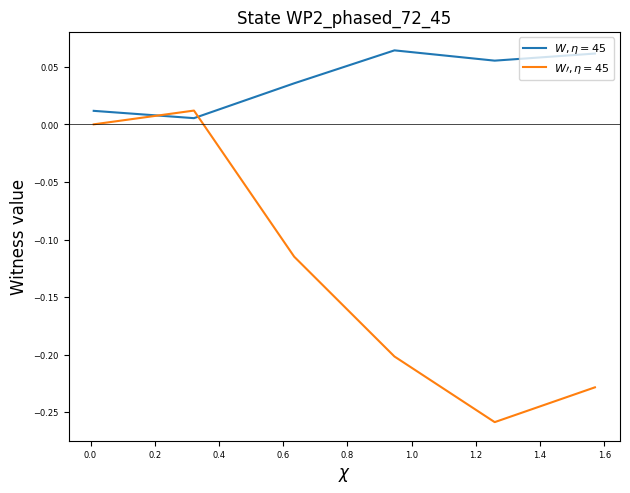

In [18]:
etas = [np.pi/4]
num_etas = len(etas)
num_chis = 6
chis = np.linspace(0.01, np.pi/2, 6) #np.linspace(0.001, np.pi/2, num_chis)
file_name = 'WP2_phased_72' # choose descriptively based on names list
names = ['cosHA_minusphasesinVD', 'cosHR_minusisinVL'] #,
probs = [0.35, 0.65] # single value list of 1 if creating a pure state #, 0.2*(np.cos(np.pi/10))**2, 0.2*(np.sin(np.pi/10))**2
eta_sweep = False # Are you sweeping over eta or chi? False if chi.
plot = True

####### Create states and get rhos  
# Instantiate states to sweep over
states_names = [[] for _ in range(num_etas)]
states = [[] for _ in range(num_etas)]
for i, eta in enumerate(etas): 
    for chi in chis:
        states_names[i].append((np.rad2deg(eta), np.rad2deg(chi)))
        states[i].append((eta, chi)) 

# Obtain the density matrix for each state
rho_actuals = [[] for _ in range(num_etas)]
for i, state_set in enumerate(states_names):
    for j, state_n in enumerate(state_set):
        rad_angles = states[i][j]
        rho_actuals[i].append(generate_state(names, probs, rad_angles))

# Instantiate lists to save as csv
W_arr = [[] for _ in range(num_etas)]  # lowest W value (4 is number of etas)
Wp_arr = [[] for _ in range(num_etas)]     # lowest W prime value
eta_arr = [[] for _ in range(num_etas)]
chi_arr = [[] for _ in range(num_etas)]

####### Witness each rho and save it

### Save witness values to above lists of lists
for i, rhos_per_eta in enumerate(rho_actuals):
    for j, rho in enumerate(rhos_per_eta):
        # find the minimum witness expectation value of the 3 w primes and of the W.
        # Add in to get which W was minimum: W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param,  verbose = True
        e = etas[i]
        c = chis[j]
        WM, WP1, WP2, WP3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param = analyze_rho(rho, verbose = True) 
        min_wp = min(WP1, WP2, WP3)
        #print('My Ws were:', WM, min_wp, 'at eta and chi:', e, c)
        print('The Ws were', WM, W_min_name, WP1,  Wp1_min_name, WP2, Wp2_min_name, WP3, Wp3_min_name)
        # Assuming that the index i corresponds to the eta trial number (0 to 3)
        W_arr[i].append(WM)
        Wp_arr[i].append(min_wp)
        eta_arr[i].append(e)
        chi_arr[i].append(c)

# Save each list to a separate CSV file
for i in range(num_etas):
    data = pd.DataFrame({
        'W': W_arr[i],
        'min_W_prime': Wp_arr[i],
        'eta_arr': eta_arr[i],
        'chi': chi_arr[i]
    })
    
    data.to_csv(f'paper_states/{file_name}_{etas[i]}.csv', index=False)
if plot == True:
        plot_all(file_name, etas, chis, eta_sweep)

In [7]:
## Testing W prime prime functionality

num_chis = 10 # number of chi points to take
num_etas = 1  # the number of etas you choose below
etas = [np.pi/4]# [np.pi/12, np.pi/6, np.pi/4 , np.pi/3]
chis = np.linspace(0.001, np.pi/2, num_chis)
file_name = 'phi_psi_bell_chi_sweep' # choose descriptively based on names list
names = ['phi plus, phi minus', 'psi plus, psi minus']
probs = [0.65, 0.35] # single value list of 1 if creating a pure state
eta_sweep = False # Are you sweeping over eta or chi? False if chi.
plot = False

####### Create states and get rhos

# Instantiate states to sweep over
states_names = [[] for _ in range(num_etas)]
states = [[] for _ in range(num_etas)]
for i, eta in enumerate(etas): 
    for chi in chis:
        states_names[i].append((np.rad2deg(eta), np.rad2deg(chi)))
        states[i].append((eta, chi)) 

# Obtain the density matrix for each state
rho_actuals = [[] for _ in range(num_etas)]
for i, state_set in enumerate(states_names):
    for j, state_n in enumerate(state_set):
        rad_angles = states[i][j]
        rho_actuals[i].append(generate_state(names, probs, rad_angles)) #name, 

# Instantiate lists to save as csv
W_arr = [[] for _ in range(num_etas)]  # lowest W value (4 is number of etas)
Wp_arr = [[] for _ in range(num_etas)]     # lowest W prime value
eta_arr = [[] for _ in range(num_etas)]
chi_arr = [[] for _ in range(num_etas)]

####### Witness each rho and save it

### Save witness values to above lists of lists
for i, rhos_per_eta in enumerate(rho_actuals):
    for j, rho in enumerate(rhos_per_eta):
        # find the minimum witness expectation value of the 3 w primes and of the W.
        # Add in to get which W was minimum: W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param,  verbose = True
        e = etas[i]
        c = chis[j]
        WM, WP1, WP2, WP3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param = analyze_rho(rho, verbose = True) 
        
        min_wp = min(WP1, WP2, WP3)
        #print('My Ws were:', WM, min_wp, 'at eta and chi:', e, c)
        print('All data was', WM, WP1, WP2, WP3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name)
        # Assuming that the index i corresponds to the eta trial number (0 to 3)
        W_arr[i].append(WM)
        Wp_arr[i].append(min_wp)
        eta_arr[i].append(e)
        chi_arr[i].append(c)

# Save each list to a separate CSV file
for i in range(num_etas):
    data = pd.DataFrame({
        'W': W_arr[i],
        'min_W_prime': Wp_arr[i],
        'eta_arr': eta_arr[i],
        'chi': chi_arr[i]
    })
    data.to_csv(f'paper_states/{file_name}_{etas[i]}.csv', index=False)
if plot == True:
        plot_all(file_name, etas, chis, eta_sweep)

All data was 9.525611e-05 6.8379604e-06 0.055097878 0.11390431 W1 Wp1 Wp6 Wp9
All data was 0.007737424 0.028496895 0.035667658 0.022908328 W2 Wp2 Wp6 Wp9
All data was 0.010851402 0.028358437 0.055306762 0.020720536 W2 Wp1 Wp6 Wp9
All data was 0.02560376 0.0007503219 0.05833441 0.08976023 W2 Wp2 Wp6 Wp9
All data was 0.04100509 -0.036757343 0.0655357 0.13119504 W2 Wp2 Wp6 Wp9
All data was 0.06349799 0.02635793 0.022726974 0.09998749 W2 Wp3 Wp6 Wp9
All data was 0.120202094 -0.09500429 0.054405514 0.1287139 W2 Wp2 Wp6 Wp9
All data was 0.120885395 -0.12725875 0.025457948 0.14700186 W2 Wp2 Wp6 Wp9
All data was 0.14463095 -0.13181026 0.00705187 0.16926323 W2 Wp3 Wp6 Wp9
All data was 0.17499998 -0.13808215 0.0041101277 0.18733071 W2 Wp3 Wp6 Wp8


### Testing all possible creatable states

In [24]:
TODO: Explain below block and what good states mean...

In [ ]:
# TODO: above...
#  Instantiate all the things we need
list_of_creatable_states = ['phi plus, phi minus', 'psi plus, psi minus', 'phi plus, psi minus', 
                            'phi minus, psi plus', 'phi plus, i psi plus', 'phi plus, i phi minus',
                            'psi plus, i psi minus', 'phi minus, i psi minus']

etas = [np.pi/12, np.pi/6, np.pi/4, np.pi/3]
chis = np.linspace(0.001, np.pi/2, 6)
num_etas = len(etas)
num_chis = len(chis)

probs = [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]

# use this to test a state that should work
#list_of_creatable_states = ['phi plus, phi minus', 'psi plus, psi minus']
#etas = [np.pi/4]
#chis = np.linspace(0.001, np.pi/2, 6)
#num_etas = len(etas)
#num_chis = len(chis)
#probs = [[0.65, 0.35]]


# Instantiate states to sweep over for every mixed state
states_names = []
states = []
for i, eta in enumerate(etas): 
    for chi in chis:
        states_names.append((np.rad2deg(eta), np.rad2deg(chi)))
        states.append((eta, chi)) 

# TODO: can we parallelize this...?
# add the state to this list whenever W is positive and W prime is negative
# each addition is of the form [[state_name_1, state_name_2], [chi, eta], [prob_1, prob_2], [W_witness_name, W_witness_value, theta], 
#                               [Wp_witness_name, Wp_witness_value, theta]]
Wh_Wpl = []
special_list = [] # this is if W > 0.2 and Wp < 0.2 (make it more obvious which are good states)
for i, state_1 in enumerate(list_of_creatable_states):
    for j, state_2 in enumerate(list_of_creatable_states):
        for l, prob in enumerate(probs):
            for k, state_set in enumerate(states_names):
                arr_to_add = []
                # get the state's density matrix
                rad_angles = states[k]
                names = [state_1, state_2]
                rho_actual = generate_state(names, prob, rad_angles)
                
                # get the important info from the state
                W_min, Wp_t1, Wp_t2, Wp_t3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param = analyze_rho(rho_actual, verbose = True)
                
                if W_min > 0.01:
                    if Wp_t1 < -0.01 or Wp_t2 < -0.01 or Wp_t3 < -0.01:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1', 'Wp2', 'Wp3']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]

                        Wh_Wpl.append(append_this)
                        print('A pretty good state was:', append_this)
                # if super good attach to special list!
                if W_min > 0.2:
                    if Wp_t1 < -0.2 or Wp_t2 < -0.2 or Wp_t3 < -0.2:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1_min_name', 'Wp2_min_name', 'Wp3_min_name']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]
                        
                        special_list.append(append_this)
                        print('An amazing state was:', append_this)
                
# save it all to csvs!                       
df_to_save = pd.DataFrame(Wh_Wpl)
df_to_save_special = pd.DataFrame(special_list)

df_to_save.to_csv(f'all_states_new.csv', index=False)
df_to_save_special.to_csv(f'special_states_new.csv', index = False)


        
                

NameError: name 'np' is not defined

In [ ]:
### This block analyzes the states produced in the above block to determine the best 20 states
import ast
df = pd.read_csv('big_run_of_states/all_states_new.csv')
# First eliminate most values for which W and W prime are off-balance
# Assumes maximal metric is 0.3.
indices_to_drop = []
for i in range(df.shape[0]):
    Wp = ast.literal_eval(df.iloc[i,4])[1]
    W = ast.literal_eval(df.iloc[i,3])[1]
    if W < 0.1 and Wp > -0.1:
    #if Wp < -0.2 or Wp > -0.1:
        indices_to_drop.append(i)
    # finding only states with W prime 2!
    # if ast.literal_eval(df.iloc[i,4])[0] != 'Wp2':
    #     indices_to_drop.append(i)
df = df.drop(indices_to_drop)
metrics = []
# Get the W and W prime value at every row and determine a metric
for i in range(df.shape[0]):
    W = ast.literal_eval(df.iloc[i,3])[1]
    Wp = ast.literal_eval(df.iloc[i,4])[1]
    metric_val = abs(W - Wp)
    metrics.append(metric_val)

# Find the greatest 20 metric values
best_twenty = sorted(metrics, reverse = True)#[:20]

# Get the rest of the data on each from the df
data = []
for val in best_twenty: #best_twenty
    index = metrics.index(val)
    data.append(df.iloc[index])
    data.append(df.iloc[index])

print(data)

    

### Testing states of the form $\frac{1+e^{i\Chi}}{2}\ket{H}\ket{H} + \frac{1-e^{i\Chi}}{2}\ket{V}\ket{V}$.
Currently, we hope to test various mixed combinations of the above state and other states we can create--the Phi Plus bell state and Psi Plus bell state.

This was computed using testing_mixed_states_cluster.py on the Physics Dept cluster and saved as ?????

Note: All states of the form 'Bell state' mixed with 'HH VV state' are not physical states, as they have coefficients that do not sum to 1. However, mixes of the form 'HH VV' with 'HR VL' or anything of the sort are done correctly. I also may not know what I'm talking about.

In [ ]:
# Analyzing csv section
# Updated to find what states are 'best' according to our metrics of most negative/positive W'/W, and taking one state from each W prime triplet. 
import ast
df = pd.read_csv('paper_states/creatable_state_run/all_good_states_test.csv')
# First eliminate most values for which W and W prime are off-balance
# Assumes maximal metric is 0.3.
indices_to_drop = []
for i in range(df.shape[0]):
    Wp = ast.literal_eval(df.iloc[i,4])[1]
    W = ast.literal_eval(df.iloc[i,3])[1]
    if W < 0.1 or Wp > -0.1:
        indices_to_drop.append(i)
    # finding only states with W prime 2!
    # if ast.literal_eval(df.iloc[i,4])[0] != 'Wp2':
    #     indices_to_drop.append(i)
df = df.drop(indices_to_drop)
metrics = []
# Get the W and W prime value at every row and determine a metric
for i in range(df.shape[0]):
    W = ast.literal_eval(df.iloc[i,3])[1]
    Wp = ast.literal_eval(df.iloc[i,4])[1]
    metric_val = abs(W - Wp)
    metrics.append(metric_val)

# Find the greatest 20 metric values
best_twenty = sorted(metrics, reverse = True)[:20]

# Get the rest of the data on each from the df
data = []
for val in best_twenty:
    index = metrics.index(val)
    data.append(df.iloc[index])
    data.append(df.iloc[index])

print(data)

In [ ]:
#  Instantiate all the things we need list_of_creatable_states = ['phi plus, phi minus', 'psi plus, psi minus', 'HR_VL', 'HR_iVL', 'HL_VR', 'HL_iVR', 'HD_VA', 'HD_iVA', 'HA_VD', 'HA_iVD']
#  Note this code was not used for our csv full of states; the cluster py file was. 
etas = [np.pi/12, np.pi/6, np.pi/4, np.pi/3, np.pi/2]
chis = np.linspace(0.001, np.pi/2, 6)
num_etas = len(etas)
num_chis = len(chis)

probs = [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]

# Instantiate states to sweep over for every mixed state
states_names = []
states = []
for i, eta in enumerate(etas): 
    for chi in chis:
        states_names.append((np.rad2deg(eta), np.rad2deg(chi)))
        states.append((eta, chi)) 

# add the state to this list whenever W is positive and W prime is negative
# each addition is of the form [[state_name_1, state_name_2], [chi, eta], [prob_1, prob_2], [W_witness_name, W_witness_value, theta], 
#                               [Wp_witness_name, Wp_witness_value, theta]]
Wh_Wpl = []
special_list = [] # this is if W > 0.2 and Wp < 0.2 (make it more obvious which are good states)
for i, state_1 in enumerate(list_of_creatable_states):
    for j, state_2 in enumerate(list_of_creatable_states):
        for l, prob in enumerate(probs):
            for k, state_set in enumerate(states_names):
                arr_to_add = []
                # get the state's density matrix
                rad_angles = states[k]
                names = [state_1, state_2]
                rho_actual = generate_state(names, prob, rad_angles)
                
                # get the important info from the state
                W_min, Wp_t1, Wp_t2, Wp_t3, W_min_name, Wp1_min_name, Wp2_min_name, Wp3_min_name, W_param, Wp1_param, Wp2_param, Wp3_param = analyze_rho(rho_actual, verbose = True)
                
                if W_min > 0.01:
                    if Wp_t1 < -0.01 or Wp_t2 < -0.01 or Wp_t3 < -0.01:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1', 'Wp2', 'Wp3']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]

                        Wh_Wpl.append(append_this)
                        print('A pretty good state was:', append_this)
                # if super good attach to special list!
                if W_min > 0.2:
                    if Wp_t1 < -0.2 or Wp_t2 < -0.2 or Wp_t3 < -0.2:
                        values = [Wp_t1, Wp_t2, Wp_t3]
                        params_prime = [Wp1_param, Wp2_param, Wp3_param]
                        names_list = ['Wp1_min_name', 'Wp2_min_name', 'Wp3_min_name']
                        min_name, min_value, min_param = min(zip(names_list, values, params_prime), key = lambda pair: pair[1])
                        append_this = [[names[0], names[1]], [state_set], prob, [W_min_name, W_min, W_param], [min_name, min_value, min_param]]
                        
                        special_list.append(append_this)
                        print('An amazing state was:', append_this)
                
# save it all to csvs!                       
df_to_save = pd.DataFrame(Wh_Wpl)
df_to_save_special = pd.DataFrame(special_list)

df_to_save.to_csv(f'paper_states/creatable_state_run/all_states_new.csv', index=False)
df_to_save_special.to_csv(f'paper_states/creatable_state_run/special_states_new.csv', index = False)